# Detecting the submesoscale: Vorticity and Rossby number 

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import matplotlib.path as mpath
from xhistogram.xarray import histogram as xhistogram

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator
import calendar

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42597/status,
Dashboard: /proxy/42597/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42581,Workers: 7
Dashboard: /proxy/42597/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:45021,Total threads: 4
Dashboard: /proxy/46283/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:39965,


In [4]:
path_output = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'
path_Plots = '/g/data/e14/cs6673/mom6_comparison/Plots_DSW/'
session = cc.database.create_session()

In [5]:
exptdict = OrderedDict([
    ('panan_01deg', # 1/10th panantarctic zstar run
     {'expt': 'panant-01-zstar-ACCESSyr2',
      'expt_name': 'panan_01deg_jra55_ryf',
      'expt_str': '1/10°'}),
    ('panan_005deg', # 1/20th panantarctic zstar run
     {'expt': 'panant-005-zstar-ACCESSyr2',
      'expt_name': 'panan_005deg_jra55_ryf',
      'expt_str': '1/20°'}),
    ('panan_0025deg', # 1/40th panantarctic zstar run
     {'expt': 'panant-0025-zstar-ACCESSyr2',
      'expt_name': 'panan_0025deg_jra55_ryf',
      'expt_str': '1/40°'})
])

In [6]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64, -66, -69, -67.5, -64],
            [-78, -78, -73, -71.5, -78]],
    'lon_min_area': [-62, 40, 115-360, 160-360],
    'lon_max_area': [-20, 80, 155-360, -160],
    'lat_min_area': [-79, -70, -70, -79],
    'lat_max_area': [-58, -62, -62, -66]}

## Load data

In [7]:
def mask_from_polygon(lon, lat, xq, yq):
    polygon = [(lon[0], lat[0])]
    for l in range(1, len(lon)):
        polygon += [(lon[l], lat[l])]
    poly_path = mpath.Path(polygon)

    x, y = xr.broadcast(xq, yq)
    coors = np.hstack((x.values.reshape(-1, 1), y.values.reshape(-1, 1)))

    mask = poly_path.contains_points(coors)
    mask = mask.reshape(xq.size, yq.size).transpose()
    mask = xr.DataArray(
        mask, dims=['yq', 'xq'], coords={'xq': xq, 'yq': yq})
    return mask

In [8]:
def shelf_mask_isobath_q_points(
    var, contour_depth, resolution, output_mask=False):
    '''
    Masks varibales by the region polewards of a given isobath
    '''

    ds_contour = xr.open_dataset(
        '/home/142/cs6673/work/mom6_comparison/Antarctic_slope_contours/' +
        'Antarctic_slope_contour_' + str(contour_depth) + 'm_MOM6_' +
        resolution + 'deg.nc')

    contour_masked_above = ds_contour.contour_masked_above
    contour_masked_above = contour_masked_above.drop_vars(
        ['xh', 'yh']).rename({'xh': 'xq', 'yh': 'yq'})
    contour_masked_above['xq'] = ds_contour.xq
    contour_masked_above['yq'] = ds_contour.yq

    # in this file the points along the isobath are given a positive value,
    # the points outside (northwards) of the isobath are given a value of
    # -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask = contour_masked_above.where(contour_masked_above == 0)+1
    shelf_mask = shelf_mask.where(shelf_mask == 1, 0)

    # multiply the variable with the mask
    masked_var = var * shelf_mask

    if output_mask == True:
        return masked_var, shelf_mask
    else:
        return masked_var

In [9]:
%%time
ekeys = ['panan_01deg', 'panan_005deg', 'panan_0025deg']
start_time = '2000-01-01'
end_time = '2001-01-01'
for ekey in ekeys:
    print(ekey)
    e = exptdict[ekey]

    e['area'] = cc.querying.getvar(
        e['expt'], 'areacello_bu', session, n=1,
        chunks={'xq': '200MB', 'yq': '200MB'}).sel(
        yq=slice(None, -55)).compute()

    for a, area_text in enumerate(DSW_region['name']):
        ds = xr.open_dataset(
            path_output + 'Velocities_vorticity_in_' + area_text + '_' +
            e['expt_name'] + '_1d_' + start_time[:4] + '.nc', chunks='auto')
        e['zeta_' + area_text[0]] = ds.zeta.compute()

        mask = mask_from_polygon(DSW_region['lon'][a], DSW_region['lat'][a],
                                 e['area'].xq, e['area'].yq)
        mask = mask.where(mask == True, 0)
        mask = shelf_mask_isobath_q_points(
            mask, contour_depth=1000, resolution=e['expt_name'].split('_')[1][:-3])
        if a == 0:
            mask_DSW = mask.expand_dims(area=[area_text])
        else:
            mask_DSW = xr.concat((mask_DSW, mask.expand_dims(
                area=[area_text])), dim='area')
    e['mask_DSW'] = mask_DSW.where(mask_DSW != 0).compute()

panan_01deg
panan_005deg
panan_0025deg
CPU times: user 48.9 s, sys: 34.3 s, total: 1min 23s
Wall time: 4min 23s


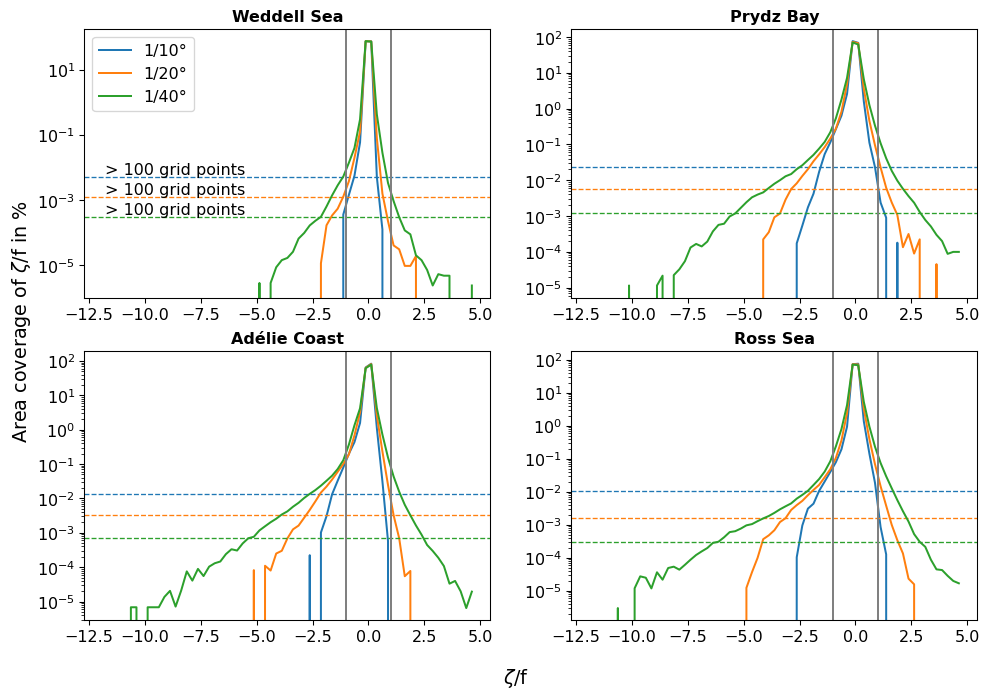

In [10]:
fig = plt.figure(figsize=(12, 8))
cols = ['tab:blue', 'tab:orange', 'tab:green']

for a, area_text in enumerate(DSW_region['name']):
    plt.subplot(2, 2, a+1)
    for p, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        area = e['area']+0*e['zeta_' + area_text[0]].where(
            e['mask_DSW'][a, :] == 1)[a, :]
        area = area / area.sum()
        hist = xhistogram(
            e['zeta_' + area_text[0]].where(e['mask_DSW'][a, :] == 1)[:151, :],
            bins=np.arange(-12, 5, .25), weights=area, block_size=None)
        hist.plot(label=e['expt_str'])
    
        num_gridp = xhistogram(
            e['zeta_' + area_text[0]].where(e['mask_DSW'][a, :] == 1)[:151, :],
            bins=np.arange(-12, 5, .25), block_size=None)
        num_gridp = hist.where(num_gridp >= 100).min().values
        plt.axhline(num_gridp, color=cols[p], linestyle='--', linewidth=1)
        if a == 0:
            plt.text(-11.8, 1.2*num_gridp, '> 100 grid points')
        plt.gca().set_yscale('log')
    plt.axvline(-1, color='grey')
    plt.axvline(1, color='grey')
    if a == 0:
        plt.legend()
    plt.title(DSW_region['name_long'][a], fontweight='bold')
    plt.xlabel('')
    plt.ylabel('')
fig.supxlabel(r'$\zeta$/f', y=.02)
fig.supylabel(r'Area coverage of $\zeta$/f in %', x=.06)
plt.show()

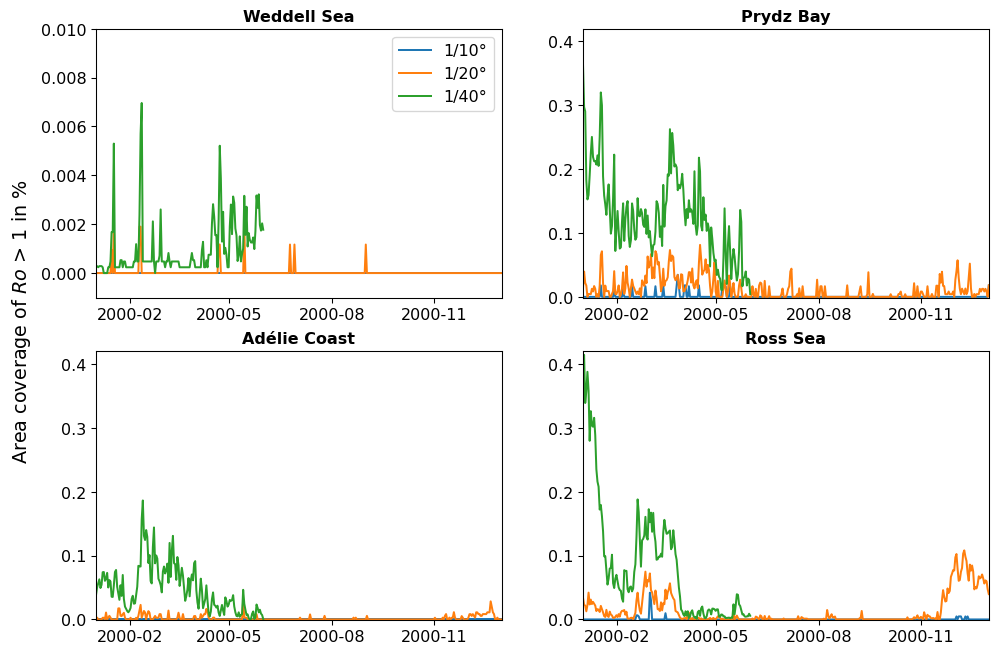

In [11]:
fig = plt.figure(figsize=(12, 8))
cols = ['tab:blue', 'tab:orange', 'tab:green']
ylim_max = [.01, .42, .42, .42]

for a, area_text in enumerate(DSW_region['name']):
    plt.subplot(2, 2, a+1)
    for p, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        area = e['area']+0*e['zeta_' + area_text[0]].where(
            e['mask_DSW'][a, :] == 1)[a, :]
        area = area / area.sum()

        area_Ro1 = area.where(np.fabs(e['zeta_' + area_text[0]] > 1)).sum(
            ['xq', 'yq'])*100
        area_Ro1.plot(label=e['expt_str'])
        plt.ylim(-.001, ylim_max[a])
    if a == 0:
        plt.legend()
    plt.title(DSW_region['name_long'][a], fontweight='bold')
    plt.xlabel('')
    plt.ylabel('')

    plt.autoscale(enable=True, axis='x', tight=True)
fig.supylabel(r'Area coverage of $Ro$ > 1 in %', x=.05)
plt.show()

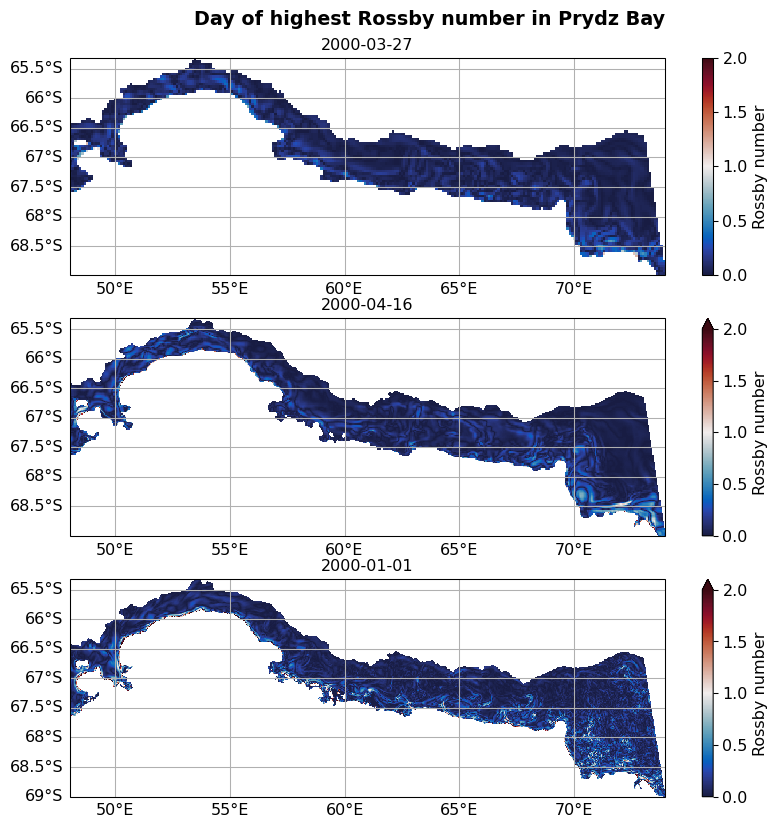

In [43]:
area_text = 'Prydz'
a = DSW_region['name'].index(area_text)

fig = plt.figure(figsize=(10, 10))
proj = ccrs.PlateCarree()
for p, ekey in enumerate(ekeys):
    if a == 3:
        ax = plt.subplot(3, 1, p+1, projection=ccrs.PlateCarree(central_longitude=180))
    else:
        ax = plt.subplot(3, 1, p+1, projection=proj)
    gl = ax.gridlines(draw_labels=False)
    gl.left_labels = True
    gl.bottom_labels = True
    ax.set_aspect('auto')
    
    e = exptdict[ekey]
    area = e['area']+0*e['zeta_' + area_text[0]].where(
        e['mask_DSW'][a, :] == 1)[a, :]
    area = area / area.sum()
    
    area_Ro1 = area.where(np.fabs(e['zeta_' + area_text[0]] > 1)).sum(
        ['xq', 'yq'])*100
    time_Ro_max = area_Ro1.argmax().values
    
    np.fabs(e['zeta_' + area_text[0]][time_Ro_max, :].where(
        e['mask_DSW'][a, :] == 1, drop=True)).plot(
        vmin=0, vmax=2, cmap=cmo.balance, transform=proj,
        cbar_kwargs={'label': "Rossby number"})
    plt.title(str(e['zeta_' + area_text[0]][time_Ro_max, :].time.values)[:10])
    
plt.suptitle('Day of highest Rossby number in ' + DSW_region['name_long'][a],
             fontweight='bold', y=.93)

plt.show()

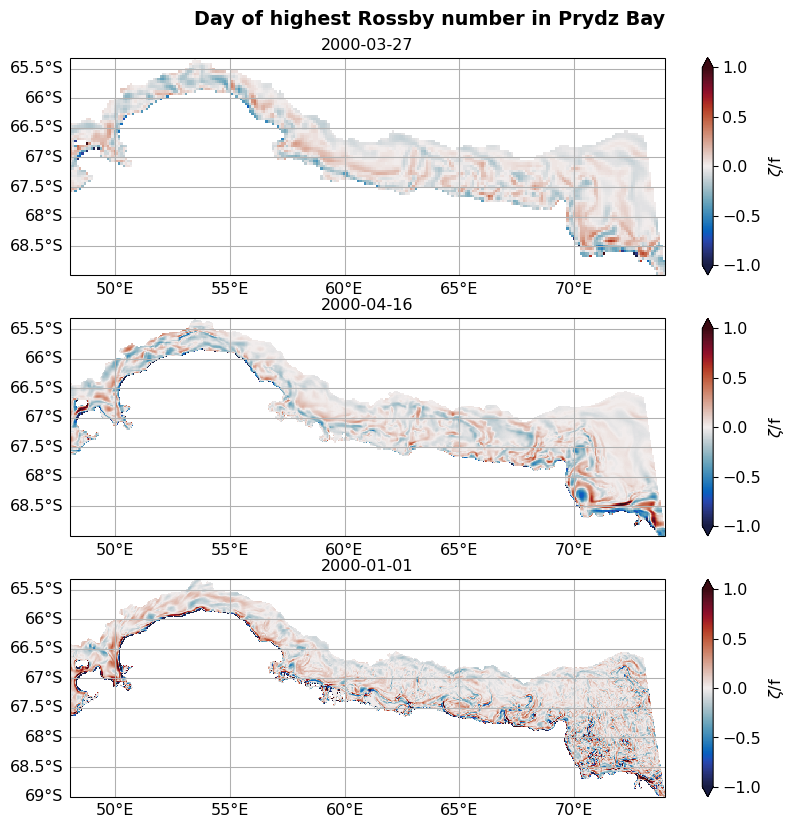

In [47]:
area_text = 'Prydz'
a = DSW_region['name'].index(area_text)

fig = plt.figure(figsize=(10, 10))
proj = ccrs.PlateCarree()
for p, ekey in enumerate(ekeys):
    if a == 3:
        ax = plt.subplot(3, 1, p+1, projection=ccrs.PlateCarree(central_longitude=180))
    else:
        ax = plt.subplot(3, 1, p+1, projection=proj)
    gl = ax.gridlines(draw_labels=False)
    gl.left_labels = True
    gl.bottom_labels = True
    ax.set_aspect('auto')
    
    e = exptdict[ekey]
    area = e['area']+0*e['zeta_' + area_text[0]].where(
        e['mask_DSW'][a, :] == 1)[a, :]
    area = area / area.sum()
    
    area_Ro1 = area.where(np.fabs(e['zeta_' + area_text[0]] > 1)).sum(
        ['xq', 'yq'])*100
    time_Ro_max = area_Ro1.argmax().values
    
    e['zeta_' + area_text[0]][time_Ro_max, :].where(
        e['mask_DSW'][a, :] == 1, drop=True).plot(
        vmin=-1, vmax=1, cmap=cmo.balance, transform=proj,
        cbar_kwargs={'label': r'$\zeta$/f'})
    plt.title(str(e['zeta_' + area_text[0]][time_Ro_max, :].time.values)[:10])
    
plt.suptitle('Day of highest Rossby number in ' + DSW_region['name_long'][a],
             fontweight='bold', y=.93)

plt.show()

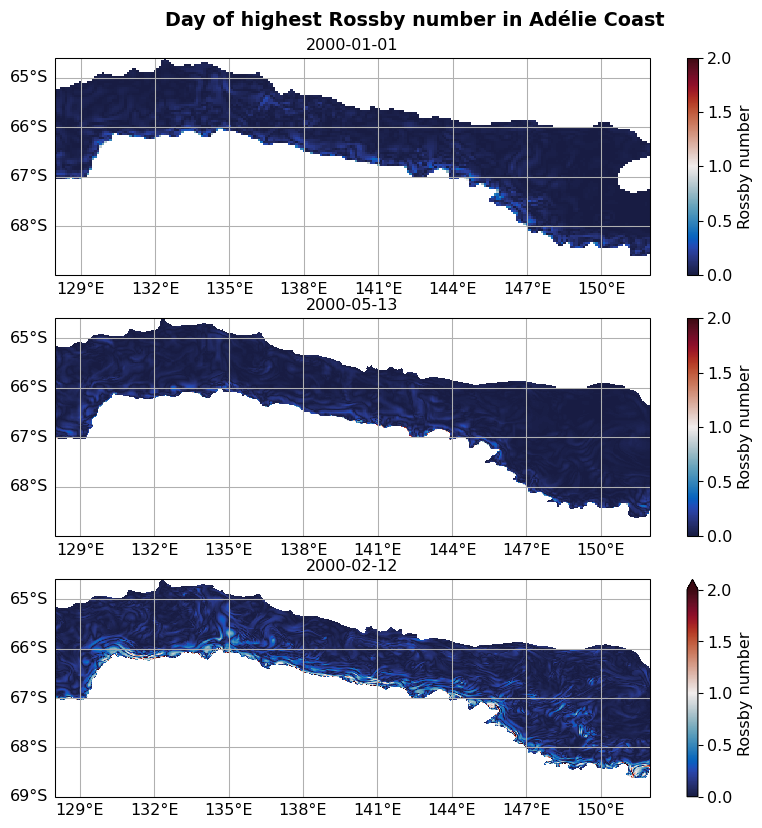

In [42]:
area_text = 'Adelie'
a = DSW_region['name'].index(area_text)

fig = plt.figure(figsize=(10, 10))
proj = ccrs.PlateCarree()
for p, ekey in enumerate(ekeys):
    if a == 3:
        ax = plt.subplot(3, 1, p+1, projection=ccrs.PlateCarree(central_longitude=180))
    else:
        ax = plt.subplot(3, 1, p+1, projection=proj)
    gl = ax.gridlines(draw_labels=False)
    gl.left_labels = True
    gl.bottom_labels = True
    ax.set_aspect('auto')
    
    e = exptdict[ekey]
    area = e['area']+0*e['zeta_' + area_text[0]].where(
        e['mask_DSW'][a, :] == 1)[a, :]
    area = area / area.sum()
    
    area_Ro1 = area.where(np.fabs(e['zeta_' + area_text[0]] > 1)).sum(
        ['xq', 'yq'])*100
    time_Ro_max = area_Ro1.argmax().values
    
    np.fabs(e['zeta_' + area_text[0]][time_Ro_max, :].where(
        e['mask_DSW'][a, :] == 1, drop=True)).plot(
        vmin=0, vmax=2, cmap=cmo.balance, transform=proj,
        cbar_kwargs={'label': "Rossby number"})
    plt.title(str(e['zeta_' + area_text[0]][time_Ro_max, :].time.values)[:10])
    
plt.suptitle('Day of highest Rossby number in ' + DSW_region['name_long'][a],
             fontweight='bold', y=.93)

plt.show()

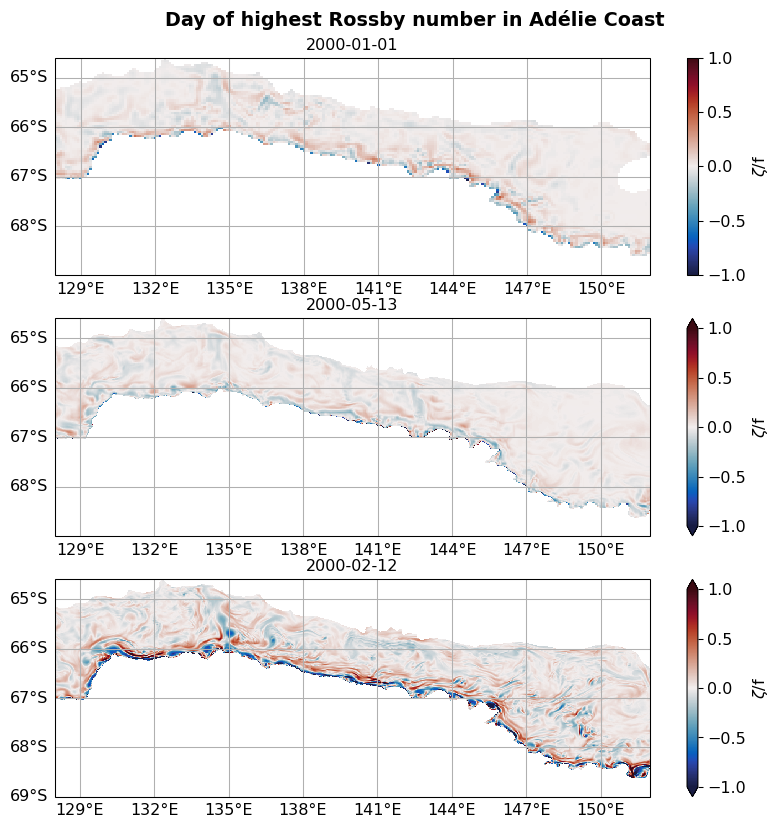

In [48]:
area_text = 'Adelie'
a = DSW_region['name'].index(area_text)

fig = plt.figure(figsize=(10, 10))
proj = ccrs.PlateCarree()
for p, ekey in enumerate(ekeys):
    if a == 3:
        ax = plt.subplot(3, 1, p+1, projection=ccrs.PlateCarree(central_longitude=180))
    else:
        ax = plt.subplot(3, 1, p+1, projection=proj)
    gl = ax.gridlines(draw_labels=False)
    gl.left_labels = True
    gl.bottom_labels = True
    ax.set_aspect('auto')
    
    e = exptdict[ekey]
    area = e['area']+0*e['zeta_' + area_text[0]].where(
        e['mask_DSW'][a, :] == 1)[a, :]
    area = area / area.sum()
    
    area_Ro1 = area.where(np.fabs(e['zeta_' + area_text[0]] > 1)).sum(
        ['xq', 'yq'])*100
    time_Ro_max = area_Ro1.argmax().values
    
    e['zeta_' + area_text[0]][time_Ro_max, :].where(
        e['mask_DSW'][a, :] == 1, drop=True).plot(
        vmin=-1, vmax=1, cmap=cmo.balance, transform=proj,
        cbar_kwargs={'label': r'$\zeta$/f'})
    plt.title(str(e['zeta_' + area_text[0]][time_Ro_max, :].time.values)[:10])
    
plt.suptitle('Day of highest Rossby number in ' + DSW_region['name_long'][a],
             fontweight='bold', y=.93)

plt.show()

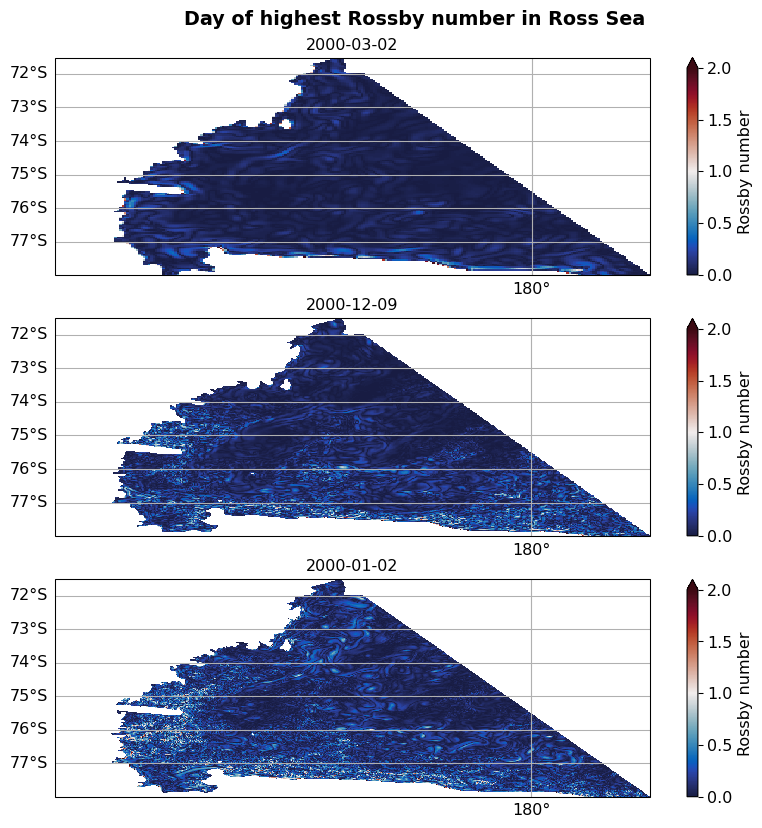

In [44]:
area_text = 'Ross'
a = DSW_region['name'].index(area_text)

fig = plt.figure(figsize=(10, 10))
proj = ccrs.PlateCarree()
for p, ekey in enumerate(ekeys):
    if a == 3:
        ax = plt.subplot(3, 1, p+1, projection=ccrs.PlateCarree(central_longitude=180))
    else:
        ax = plt.subplot(3, 1, p+1, projection=proj)
    gl = ax.gridlines(draw_labels=False)
    gl.left_labels = True
    gl.bottom_labels = True
    ax.set_aspect('auto')
    
    e = exptdict[ekey]
    area = e['area']+0*e['zeta_' + area_text[0]].where(
        e['mask_DSW'][a, :] == 1)[a, :]
    area = area / area.sum()
    
    area_Ro1 = area.where(np.fabs(e['zeta_' + area_text[0]] > 1)).sum(
        ['xq', 'yq'])*100
    time_Ro_max = area_Ro1.argmax().values
    
    np.fabs(e['zeta_' + area_text[0]][time_Ro_max, :].where(
        e['mask_DSW'][a, :] == 1, drop=True)).plot(
        vmin=0, vmax=2, cmap=cmo.balance, transform=proj,
        cbar_kwargs={'label': "Rossby number"})
    plt.title(str(e['zeta_' + area_text[0]][time_Ro_max, :].time.values)[:10])
    
plt.suptitle('Day of highest Rossby number in ' + DSW_region['name_long'][a],
             fontweight='bold', y=.93)

plt.show()

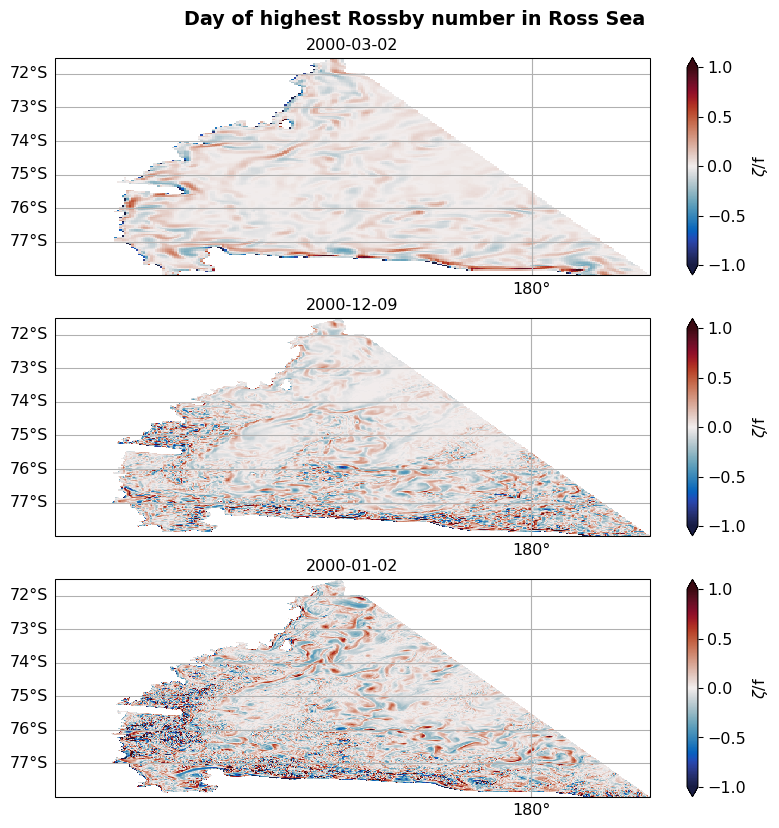

In [49]:
area_text = 'Ross'
a = DSW_region['name'].index(area_text)

fig = plt.figure(figsize=(10, 10))
proj = ccrs.PlateCarree()
for p, ekey in enumerate(ekeys):
    if a == 3:
        ax = plt.subplot(3, 1, p+1, projection=ccrs.PlateCarree(central_longitude=180))
    else:
        ax = plt.subplot(3, 1, p+1, projection=proj)
    gl = ax.gridlines(draw_labels=False)
    gl.left_labels = True
    gl.bottom_labels = True
    ax.set_aspect('auto')
    
    e = exptdict[ekey]
    area = e['area']+0*e['zeta_' + area_text[0]].where(
        e['mask_DSW'][a, :] == 1)[a, :]
    area = area / area.sum()
    
    area_Ro1 = area.where(np.fabs(e['zeta_' + area_text[0]] > 1)).sum(
        ['xq', 'yq'])*100
    time_Ro_max = area_Ro1.argmax().values
    
    e['zeta_' + area_text[0]][time_Ro_max, :].where(
        e['mask_DSW'][a, :] == 1, drop=True).plot(
        vmin=-1, vmax=1, cmap=cmo.balance, transform=proj,
        cbar_kwargs={'label': r'$\zeta$/f'})
    plt.title(str(e['zeta_' + area_text[0]][time_Ro_max, :].time.values)[:10])
    
plt.suptitle('Day of highest Rossby number in ' + DSW_region['name_long'][a],
             fontweight='bold', y=.93)

plt.show()

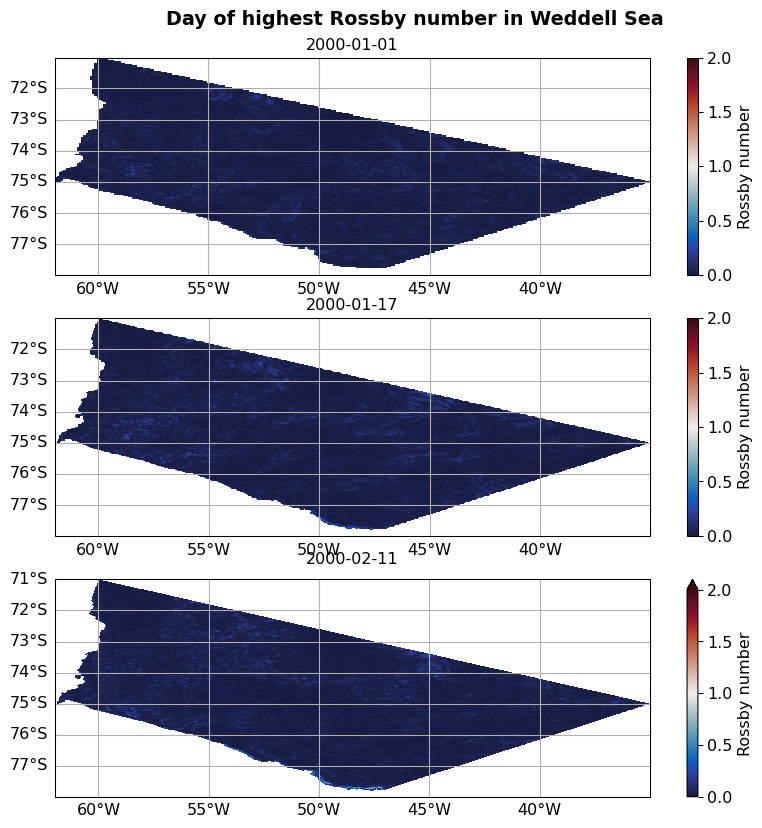

In [45]:
area_text = 'Weddell'
a = DSW_region['name'].index(area_text)

fig = plt.figure(figsize=(10, 10))
proj = ccrs.PlateCarree()
for p, ekey in enumerate(ekeys):
    if a == 3:
        ax = plt.subplot(3, 1, p+1, projection=ccrs.PlateCarree(central_longitude=180))
    else:
        ax = plt.subplot(3, 1, p+1, projection=proj)
    gl = ax.gridlines(draw_labels=False)
    gl.left_labels = True
    gl.bottom_labels = True
    ax.set_aspect('auto')
    
    e = exptdict[ekey]
    area = e['area']+0*e['zeta_' + area_text[0]].where(
        e['mask_DSW'][a, :] == 1)[a, :]
    area = area / area.sum()
    
    area_Ro1 = area.where(np.fabs(e['zeta_' + area_text[0]] > 1)).sum(
        ['xq', 'yq'])*100
    time_Ro_max = area_Ro1.argmax().values
    
    np.fabs(e['zeta_' + area_text[0]][time_Ro_max, :].where(
        e['mask_DSW'][a, :] == 1, drop=True)).plot(
        vmin=0, vmax=2, cmap=cmo.balance, transform=proj,
        cbar_kwargs={'label': "Rossby number"})
    plt.title(str(e['zeta_' + area_text[0]][time_Ro_max, :].time.values)[:10])
    
plt.suptitle('Day of highest Rossby number in ' + DSW_region['name_long'][a],
             fontweight='bold', y=.93)

plt.show()

# To do


look at stratification changes